# Modeles

https://www.kaggle.com/c/home-credit-default-risk

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import pandas as pd

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

import xgboost as xgb

import lightgbm as lgbm


import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
#import gc

# bokeh basics

#from bokeh.plotting import figure
#from bokeh.io import show, output_notebook

pd.set_option('display.max_columns', 200) #Pour avoir accès à toutes les colonnes dans la méthode display
pd.set_option('display.max_rows', 200) #Pour avoir accès à toutes les colonnes dans la méthode display
pd.set_option('max_colwidth', 255) 

In [3]:
def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')

In [4]:
# Read train/test table
train = pd.read_csv('m_train.csv', index_col = 'SK_ID_CURR')

In [5]:
train

,CREDIT_TERM,DAYS_BIRTH,DAYS_EMPLOYED,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,client_installments_AMT_PAYMENT_min_sum,DAYS_ID_PUBLISH,bureau_AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT,bureau_DAYS_CREDIT_max,ANNUITY_INCOME_PERCENT,DAYS_REGISTRATION,client_cash_CNT_INSTALMENT_FUTURE_mean_max,bureau_DAYS_CREDIT_ENDDATE_max,client_installments_AMT_PAYMENT_min_min,previous_HOUR_APPR_PROCESS_START_mean,CODE_GENDER_F,client_installments_AMT_PAYMENT_min_mean,REGION_POPULATION_RELATIVE,client_installments_AMT_PAYMENT_sum_mean,bureau_DAYS_CREDIT_mean,client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_min,previous_CNT_PAYMENT_mean,CREDIT_INCOME_PERCENT,REGION_RATING_CLIENT,client_cash_CNT_INSTALMENT_FUTURE_min_max,client_cash_SK_DPD_DEF_mean_mean,client_cash_CNT_INSTALMENT_FUTURE_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,previous_AMT_DOWN_PAYMENT_max,bureau_AMT_CREDIT_SUM_mean,bureau_CREDIT_ACTIVE_Active_sum,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_DAYS_ENDDATE_FACT_max,previous_RATE_DOWN_PAYMENT_max,previous_NAME_CONTRACT_STATUS_Refused_mean,previous_DAYS_DECISION_max,bureau_AMT_CREDIT_SUM_min,previous_NAME_YIELD_GROUP_low_action_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_AMT_CREDIT_SUM_DEBT_max,previous_SELLERPLACE_AREA_mean,NAME_EDUCATION_TYPE_Highereducation,client_credit_CNT_DRAWINGS_CURRENT_max_min,client_installments_DAYS_ENTRY_PAYMENT_sum_max,client_installments_DAYS_ENTRY_PAYMENT_max_mean,previous_SELLERPLACE_AREA_max,bureau_DAYS_CREDIT_ENDDATE_sum,OWN_CAR_AGE,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_MAX_OVERDUE_mean,client_installments_AMT_PAYMENT_min_max,bureau_DAYS_CREDIT_ENDDATE_mean,client_installments_AMT_INSTALMENT_max_max,bureau_CREDIT_TYPE_Mortgage_mean,previous_NAME_YIELD_GROUP_high_mean,NAME_FAMILY_STATUS_Married,previous_PRODUCT_COMBINATION_CashXSelllow_mean,AMT_INCOME_TOTAL,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_AMT_PAYMENT_mean_max,client_installments_AMT_PAYMENT_mean_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,previous_DAYS_DECISION_mean,client_cash_CNT_INSTALMENT_FUTURE_mean_min,client_installments_AMT_INSTALMENT_min_min,previous_AMT_ANNUITY_max,client_installments_NUM_INSTALMENT_VERSION_sum_mean,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_INSTALMENT_max_sum,previous_AMT_CREDIT_mean,previous_AMT_ANNUITY_mean,client_installments_DAYS_ENTRY_PAYMENT_min_mean,previous_RATE_DOWN_PAYMENT_sum,client_installments_AMT_INSTALMENT_max_min,previous_CNT_PAYMENT_sum,previous_AMT_ANNUITY_min,client_cash_NAME_CONTRACT_STATUS_Active_sum_mean,previous_AMT_GOODS_PRICE_min,client_cash_MONTHS_BALANCE_sum_max,previous_RATE_DOWN_PAYMENT_mean,previous_NAME_CONTRACT_STATUS_Approved_mean,previous_NAME_TYPE_SUITE_Unaccompanied_mean,bureau_AMT_CREDIT_SUM_sum,FLAG_OWN_CAR,previous_DAYS_DECISION_min,previous_CNT_PAYMENT_max,previous_DAYS_LAST_DUE_1ST_VERSION_sum,client_installments_AMT_INSTALMENT_min_sum,NAME_CONTRACT_TYPE,previous_AMT_DOWN_PAYMENT_mean,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,previous_HOUR_APPR_PROCESS_START_max,client_installments_AMT_PAYMENT_mean_mean,previous_DAYS_LAST_DUE_1ST_VERSION_min,bureau_DAYS_CREDIT_min,FLAG_DOCUMENT_3,previous_AMT_CREDIT_max,previous_DAYS_FIRST_DUE_mean,...,previous_NAME_YIELD_GROUP_XNA_mean,client_cash_CNT_INSTALMENT_min_min,client_bureau_balance_MONTHS_BALANCE_max_mean,previous_CHANNEL_TYPE_APCashloan_mean,previous_NAME_SELLER_INDUSTRY_Connectivity_mean,previous_NAME_SELLER_INDUSTRY_Connectivity_sum,ORGANIZATION_TYPE_BusinessEntityType3,OCCUPATION_TYPE_Highskilltechstaff,previous_NAME_SELLER_INDUSTRY_XNA_mean,client_cash_NAME_CONTRACT_STATUS_Completed_mean_min,client_installments_NUM_INSTALMENT_NUMBER_min_max,client_bureau_balance_STATUS_C_sum_max,NAME_INCOME_TYPE_Stateservant,previous_NAME_CASH_LOAN_PURPOSE_XNA_mean,client_cash_CNT_INSTALMENT_min_max,client_credit_AMT_DRAWINGS_POS_CURRENT_max_min,previous_NAME_CONTRACT_STATUS_Canceled_mean,client_credit_AMT_DRAWINGS_CURRENT_sum_min,client_bureau_balance_MO

In [6]:
# pour créer un sous ensemble équilibré en TARGET
train_equilibre = train.groupby('TARGET').apply(lambda x: x.sample(n=8000)).reset_index(drop = True)

In [7]:
X = train_equilibre.drop(['TARGET'], axis=1)
y = train_equilibre['TARGET']

In [8]:
y.value_counts()

False    8000
True     8000
Name: TARGET, dtype: int64

# TROUVER LES HYPERPARAMETRES par Hyperopt
## LightGBM

In [9]:
def objective(params):
    params = {'boosting_type' : params['boosting_type'],
        'num_leaves': int(params['num_leaves']),
              'colsample_bytree': '{:.3f}'.format(params['colsample_bytree'])}
    clf = lgbm.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        **params)
    
    # L'objectif est de maximiser AUC - pour hyperopt on veut minimiser le score
    # d'où le 1-ROCAUC
    score = 1 - cross_val_score(clf, X, y, scoring='roc_auc', cv=10).mean()
    print("ROC-AUC {:.3f} params {}".format(score, params))
    return score


space = {
    'boosting_type' : hp.choice('boosting_type', ('gbdt','dart','goss')),
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}


best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30)

ROC-AUC 0.260 params {'boosting_type': 'gbdt', 'num_leaves': 12, 'colsample_bytree': '0.901'}
ROC-AUC 0.256 params {'boosting_type': 'goss', 'num_leaves': 54, 'colsample_bytree': '0.695'}
ROC-AUC 0.263 params {'boosting_type': 'dart', 'num_leaves': 124, 'colsample_bytree': '0.378'}
ROC-AUC 0.258 params {'boosting_type': 'goss', 'num_leaves': 68, 'colsample_bytree': '0.706'}
ROC-AUC 0.257 params {'boosting_type': 'goss', 'num_leaves': 62, 'colsample_bytree': '0.375'}
ROC-AUC 0.267 params {'boosting_type': 'dart', 'num_leaves': 52, 'colsample_bytree': '0.537'}
ROC-AUC 0.254 params {'boosting_type': 'gbdt', 'num_leaves': 58, 'colsample_bytree': '0.640'}
ROC-AUC 0.267 params {'boosting_type': 'dart', 'num_leaves': 110, 'colsample_bytree': '0.818'}
ROC-AUC 0.260 params {'boosting_type': 'goss', 'num_leaves': 116, 'colsample_bytree': '0.309'}
ROC-AUC 0.258 params {'boosting_type': 'goss', 'num_leaves': 94, 'colsample_bytree': '0.616'}
ROC-AUC 0.272 params {'boosting_type': 'dart', 'num_leave

# Créer un scorer 
- Imaginons que l'organisme de crédit perde 10.000 par crédit remboursé "manqué" (faux positif)
- Qu'il perde 100.000 par crédit accepté non remboursé (faux négatif).

In [10]:
def scoring_fcn(y_true, y_pred, cout_FN = 100000, cout_FP = 10000):
    # Cout des faux negatifs: 
    loss_function = cout_FN* sum((1-y_true)*(y_pred))
    # Cout des faux positifs
    loss_function += cout_FP* sum((y_true)*(1-y_pred))
    
    return loss_function/len(y_true)

- Créer un autre sous-ensemble équilibré en TARGET
- Faire tourner le modèle avec les hyperparamètres trouvés précédemment, sur le sous-ensemble
- Récupérer le modèle pour pouvoir l'appeler ensuite avec une api

In [11]:
y_true = np.array([0,0,1,1,0,1])
y_pred = np.array([1,0,1,0,1,1])

scoring_fcn(y_true, y_pred)

35000.0

In [12]:
def objective_weighted(params):
    params = {'boosting_type' : params['boosting_type'],
        'num_leaves': int(params['num_leaves']),
              'colsample_bytree': '{:.3f}'.format(params['colsample_bytree'])}
    clf = lgbm.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        **params)
    
    # L'objectif est de minimiser la "loss fonction" définie par la fonction scoring_fcn
    
    
    from sklearn.metrics import make_scorer
    
    score = cross_val_score(clf, X, y, scoring=make_scorer(scoring_fcn), cv=10).mean()
    print("loss_function {:.3f} params {}".format(score, params))
    return score


space = {
    'boosting_type' : hp.choice('boosting_type', ('gbdt','dart','goss')),
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}


best = fmin(fn=objective_weighted,
            space=space,
            algo=tpe.suggest,
            max_evals=30)

loss_function 18057.500 params {'boosting_type': 'dart', 'num_leaves': 86, 'colsample_bytree': '0.798'}
loss_function 17351.875 params {'boosting_type': 'gbdt', 'num_leaves': 92, 'colsample_bytree': '0.600'}
loss_function 17918.125 params {'boosting_type': 'dart', 'num_leaves': 66, 'colsample_bytree': '0.630'}
loss_function 18233.750 params {'boosting_type': 'dart', 'num_leaves': 110, 'colsample_bytree': '0.929'}
loss_function 17993.125 params {'boosting_type': 'dart', 'num_leaves': 76, 'colsample_bytree': '0.436'}
loss_function 17735.000 params {'boosting_type': 'goss', 'num_leaves': 62, 'colsample_bytree': '0.688'}
loss_function 18066.250 params {'boosting_type': 'goss', 'num_leaves': 120, 'colsample_bytree': '0.845'}
loss_function 17316.875 params {'boosting_type': 'gbdt', 'num_leaves': 54, 'colsample_bytree': '0.466'}
loss_function 17523.750 params {'boosting_type': 'goss', 'num_leaves': 24, 'colsample_bytree': '0.978'}
loss_function 17931.250 params {'boosting_type': 'goss', 'num_

In [13]:
best

{'boosting_type': 0,
 'colsample_bytree': 0.4392920669309776,
 'num_leaves': 58.0}

# Entrainer le scorer sur un plus gros set, pour l'utiliser ensuite

In [14]:
train['TARGET'].value_counts()

False    282686
True      24825
Name: TARGET, dtype: int64

In [15]:
# pour créer un sous ensemble équilibré en TARGET
train_equilibre = train.groupby('TARGET').apply(lambda x: x.sample(n=24000)).reset_index(drop = True)
X = train_equilibre.drop(['TARGET'], axis=1)
y = train_equilibre['TARGET']
y.value_counts()

False    24000
True     24000
Name: TARGET, dtype: int64

In [16]:
clf_final = lgbm.LGBMClassifier(n_estimators=500, learning_rate=0.01, boosting_type = 'gbdt',
 colsample_bytree = 0.34498171930745564,
 num_leaves = 90)
clf_final.fit(X,y)

LGBMClassifier(colsample_bytree=0.34498171930745564, learning_rate=0.01,
               n_estimators=500, num_leaves=90)

In [17]:
y_pred = clf_final.predict(X)
scoring_fcn(y, y_pred)

11539.166666666666

In [18]:
clf_final

LGBMClassifier(colsample_bytree=0.34498171930745564, learning_rate=0.01,
               n_estimators=500, num_leaves=90)

In [19]:
# Save classifier
import pickle
# save the model to disk
filename = 'app/models/finalized_model.sav'
pickle.dump(clf_final, open(filename, 'wb'))

# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [20]:
clf_final.predict(X.loc[10002,:].to_numpy().reshape(1,-1) )

array([ True])

In [21]:
test = pd.read_csv('m_test.csv', index_col = 'SK_ID_CURR')

In [22]:
Y_TEST_PREDICT = clf_final.predict(test)

In [24]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [38]:
feature_importances = pd.DataFrame({'feature': list(X.columns), 
                                    'importance': clf_final.feature_importances_}).sort_values('importance',
                                                                                               ascending = False)
feature_importances['relative_importance'] = 100*feature_importances['importance']/sum(feature_importances['importance'])
feature_importances.head(10)

,feature,importance,relative_importance
0,CREDIT_TERM,1649,3.705618
2,DAYS_EMPLOYED,699,1.570787
4,DAYS_LAST_PHONE_CHANGE,671,1.507865
1,DAYS_BIRTH,614,1.379775
5,client_installments_AMT_PAYMENT_min_sum,599,1.346067
3,AMT_ANNUITY,569,1.278652
8,AMT_CREDIT,544,1.222472
12,client_cash_CNT_INSTALMENT_FUTURE_mean_max,527,1.184270
9,bureau_DAYS_CREDIT_max,516,1.159551
6,DAYS_ID_PUBLISH,510,1.146067


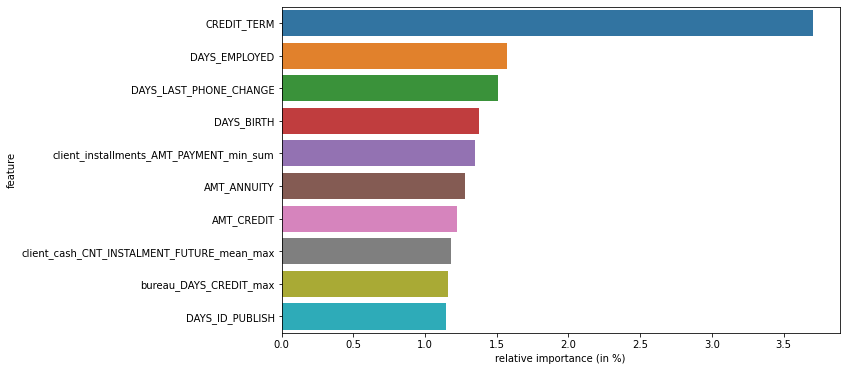

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,6))
sns.barplot(x='relative_importance', y='feature', data = feature_importances.head(10))
plt.xlabel('relative importance (in %)');

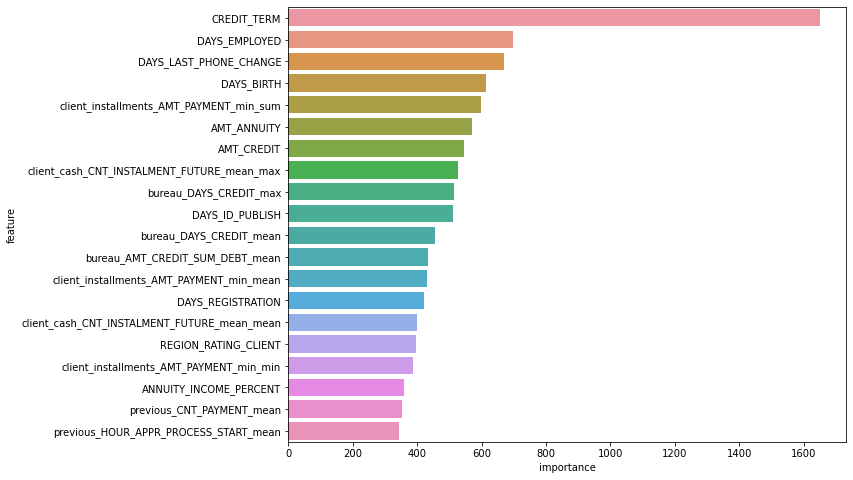

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='feature', data = feature_importances.head(20));

In [32]:
feature_importances['relative_importance']

0      3.705618
2      1.570787
4      1.507865
1      1.379775
5      1.346067
         ...   
298    0.004494
291    0.002247
271    0.000000
304    0.000000
307    0.000000
Name: relative_importance, Length: 346, dtype: float64